In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
model_base_name = '250000spec_800MHz_RAE_ExtendedRange_MoreLeftOut_Combined1Distribution_OptParams'
base_name = '250000spec_800MHz_ExtendedRange_MoreLeftOut_Combined1Distribution'    # This is the dataset base name
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [4]:
# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra_filename = f'Dataset44_{base_name}_ForManuscript_Spec.dat'
conc1_filename = f'Dataset44_{base_name}_ForManuscript_Conc.npy'

spectra_shape = (249996, 46000)
conc1_shape = (249996, 44)


# Load the memmap arrays
spectra_memmap = np.memmap(spectra_filename, dtype=np.float64, mode='r', shape=spectra_shape)
conc1_memmap = np.load(conc1_filename)

# Split into testing and training data
X_train_indices, X_test_indices, y_train_indices, y_test_indices = train_test_split(
    np.arange(spectra_shape[0]), np.arange(conc1_shape[0]), test_size=0.2, random_state=1
)

# Create custom dataset class
class NMRDataset(torch.utils.data.Dataset):
    def __init__(self, spectra_memmap, conc1_memmap, indices):
        self.spectra_memmap = spectra_memmap
        self.conc1_memmap = conc1_memmap
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        X = self.spectra_memmap[actual_idx]
        y = self.conc1_memmap[actual_idx]
        return torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)
    

# Create datasets
train_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_train_indices)
test_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_test_indices)


# Create DataLoaders
batch_size = 61  
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first = True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(47104, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = self.transformer_encoder(x)  # (batch_size, num_bins, d_model)

        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 500  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 16         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 512  # Feedforward dimension
dropout = 0.0     # Dropout rate

## Best parameters from Optuna hyperparameter optimization
#{'n_layers': 1, 
# 'input_dim': 500, 
# 'd_model': 512, 
# 'nhead': 16, 
# 'num_encoder_layers': 1, 
# 'dim_feedforward': 512, 
# 'bs': 61, 
# 'learning_rate': 0.0004977471527512947, 
# 'reg_strength': 0.009588510882049478}

In [6]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [7]:
from torch.cuda.amp import GradScaler, autocast

def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.0004977471527512947, weight_decay=0.009588510882049478)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping
    accumulation_steps = 4
    
    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        ## Training phase
        # Instantiate the GradScaler
        scaler = GradScaler()
        optimizer.zero_grad()  # Only zero gradients here at the start of an epoch
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Enable autocasting for forward and backward passes
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Scale the loss to account for the accumulation steps
                loss = loss / accumulation_steps
            train_loss += loss.item() * inputs.size(0)
            # Scale the loss and perform backpropagation
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Step the optimizer and update the scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Zero gradients after accumulation_steps

        # Testing phase
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
        
        
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [8]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 21398.2433, Test Loss: 11527.9003
Epoch time:  448.33838748931885
Epoch [2/1000], Train Loss: 6604.7868, Test Loss: 3319.6488
Epoch time:  177.38281178474426
Epoch [3/1000], Train Loss: 2511.7822, Test Loss: 2150.6542
Epoch time:  172.03511142730713
Epoch [4/1000], Train Loss: 2100.0641, Test Loss: 1488.6949
Epoch time:  177.86325860023499
Epoch [5/1000], Train Loss: 1388.6079, Test Loss: 1316.1970
Epoch time:  176.93382453918457
Epoch [6/1000], Train Loss: 5482.6321, Test Loss: 4996.6855
Epoch time:  176.67638850212097
Epoch [7/1000], Train Loss: 1787.3482, Test Loss: 1191.4374
Epoch time:  170.27201223373413
Epoch [8/1000], Train Loss: 1204.1275, Test Loss: 1066.1595
Epoch time:  174.95119857788086
Epoch [9/1000], Train Loss: 1062.5984, Test Loss: 1011.4384
Epoch time:  177.16387367248535
Epoch [10/1000], Train Loss: 1373.7640, Test Loss: 952.7680
Epoch time:  190.26724576950073
Epoch [11/1000], Train Loss:

Epoch [91/1000], Train Loss: 443.0057, Test Loss: 441.7265
Epoch time:  79.81134796142578
Epoch [92/1000], Train Loss: 447.7881, Test Loss: 467.9587
Epoch time:  76.50154852867126
Epoch [93/1000], Train Loss: 458.0545, Test Loss: 481.3478
Epoch time:  81.69860792160034
Epoch [94/1000], Train Loss: 460.7204, Test Loss: 434.7290
Epoch time:  78.36654949188232
Epoch [95/1000], Train Loss: 855.4798, Test Loss: 436.5129
Epoch time:  84.36458325386047
Epoch [96/1000], Train Loss: 432.9611, Test Loss: 391.2074
Epoch time:  84.11960935592651
Epoch [97/1000], Train Loss: 443.3328, Test Loss: 472.4048
Epoch time:  83.29991602897644
Epoch [98/1000], Train Loss: 448.1107, Test Loss: 425.9826
Epoch time:  76.32339453697205
Epoch [99/1000], Train Loss: 458.5999, Test Loss: 408.7267
Epoch time:  82.28896713256836
Epoch [100/1000], Train Loss: 980.9364, Test Loss: 405.8473
Epoch time:  70.48155999183655
Epoch [101/1000], Train Loss: 414.7696, Test Loss: 455.1457
Epoch time:  61.448293685913086
Epoch [

Epoch [181/1000], Train Loss: 396.2904, Test Loss: 417.7857
Epoch time:  60.10001015663147
Epoch [182/1000], Train Loss: 395.6467, Test Loss: 384.3594
Epoch time:  59.94425415992737
Epoch [183/1000], Train Loss: 400.7353, Test Loss: 431.7959
Epoch time:  59.69592785835266
Epoch [184/1000], Train Loss: 2587.2614, Test Loss: 361.6131
Epoch time:  59.69996976852417
Epoch [185/1000], Train Loss: 408.7453, Test Loss: 377.8801
Epoch time:  59.738850593566895
Epoch [186/1000], Train Loss: 385.5011, Test Loss: 427.7969
Epoch time:  68.73748755455017
Epoch [187/1000], Train Loss: 382.6930, Test Loss: 380.8184
Epoch time:  63.84514403343201
Epoch [188/1000], Train Loss: 390.8927, Test Loss: 361.3076
Epoch time:  59.37260866165161
Epoch [189/1000], Train Loss: 1029.2313, Test Loss: 551.5684
Epoch time:  59.35581159591675
Epoch [190/1000], Train Loss: 395.5844, Test Loss: 363.8985
Epoch time:  59.30862641334534
Epoch [191/1000], Train Loss: 364.5612, Test Loss: 370.8772
Epoch time:  59.33110618591

Epoch [271/1000], Train Loss: 366.0848, Test Loss: 361.9362
Epoch time:  59.659018754959106
Epoch [272/1000], Train Loss: 1066.1872, Test Loss: 865.8823
Epoch time:  60.22502326965332
Epoch [273/1000], Train Loss: 381.8118, Test Loss: 360.1962
Epoch time:  69.27405977249146
Epoch [274/1000], Train Loss: 346.4994, Test Loss: 346.4414
Epoch time:  65.07506585121155
Epoch [275/1000], Train Loss: 360.7710, Test Loss: 346.6239
Epoch time:  59.89658999443054
Epoch [276/1000], Train Loss: 413.2069, Test Loss: 452.4006
Epoch time:  59.84817838668823
Epoch [277/1000], Train Loss: 363.6870, Test Loss: 318.6701
Epoch time:  61.33610200881958
Epoch [278/1000], Train Loss: 363.8494, Test Loss: 391.3449
Epoch time:  63.67704749107361
Epoch [279/1000], Train Loss: 3446.3098, Test Loss: 376.5205
Epoch time:  70.01465702056885
Epoch [280/1000], Train Loss: 396.9830, Test Loss: 420.5120
Epoch time:  70.0047492980957
Epoch [281/1000], Train Loss: 368.2484, Test Loss: 337.1582
Epoch time:  70.757582426071

In [9]:
np.array(test_losses).min()

309.6456815651618

In [10]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [11]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

Transformer(
  (embedding): Linear(in_features=500, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=47104, out_features=44, bias=True)
)

In [12]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[22.4850,  9.9595, 16.7302,  6.4335, 16.3450,  4.4282, 13.1104,  1.8892,
          6.9682,  3.0391,  5.2802,  8.4470, 11.2913, 12.1202, 23.6381, 16.7295,
          5.1858, 13.6136,  8.5130, 22.8591, 22.7535,  9.7483, 10.4091, 23.2885,
         16.9911,  6.9668, 18.2339, 10.5384, 13.2913, 19.8649, 17.3550,  6.4241,
          8.6934, 11.9735,  9.8628,  2.7203, 15.5459,  5.1349, 14.2338, 21.1537,
         11.4387, 19.0823,  5.2659,  8.3218]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [13]:
Prediction.detach().cpu().numpy()[0]

array([22.485    ,  9.959549 , 16.730158 ,  6.43349  , 16.345049 ,
        4.4281883, 13.1103735,  1.8891624,  6.968176 ,  3.039127 ,
        5.2802343,  8.447043 , 11.291328 , 12.120153 , 23.638147 ,
       16.729515 ,  5.185848 , 13.613619 ,  8.513045 , 22.859125 ,
       22.753485 ,  9.748326 , 10.409055 , 23.28848  , 16.991116 ,
        6.966781 , 18.233862 , 10.538354 , 13.291252 , 19.864859 ,
       17.354998 ,  6.4240837,  8.693368 , 11.973511 ,  9.862793 ,
        2.7202785, 15.545865 ,  5.1349454, 14.233833 , 21.153696 ,
       11.438664 , 19.082346 ,  5.2659154,  8.321838 ], dtype=float32)

In [14]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  34.10462344538659


In [15]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
31.29  - Concentrations: 0.004999999888241291
6.34  - Concentrations: 0.02500000037252903
1.55  - Concentrations: 0.10000000149011612
0.85  - Concentrations: 0.25
0.57  - Concentrations: 0.5
0.45  - Concentrations: 1.0
0.49  - Concentrations: 2.5
0.34  - Concentrations: 10.0
0.73  - Concentrations: 20.0


In [16]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  1.1733705
--------------------
0.56  - Min Value: 0.6783  - Mean Value: 9.2
5.31  - Min Value: 0.0096  - Mean Value: 10.3
1.43  - Min Value: 0.147  - Mean Value: 10.5
0.66  - Min Value: 0.5572  - Mean Value: 8.5
0.63  - Min Value: 1.3567  - Mean Value: 10.6
0.51  - Min Value: 0.6332  - Mean Value: 10.9
0.73  - Min Value: 0.7017  - Mean Value: 11.0
1.02  - Min Value: 0.3674  - Mean Value: 8.9
0.53  - Min Value: 0.8387  - Mean Value: 9.8
0.36  - Min Value: 1.0913  - Mean Value: 11.1


In [17]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  2.6579187
--------------------
2.34  - Min Value: 0.0111  - Mean Value: 0.1
2.5  - Min Value: 0.0103  - Mean Value: 0.1
2.18  - Min Value: 0.0153  - Mean Value: 0.1
2.65  - Min Value: 0.0117  - Mean Value: 0.1
2.18  - Min Value: 0.0089  - Mean Value: 0.1
4.4  - Min Value: 0.0075  - Mean Value: 0.1
3.18  - Min Value: 0.0117  - Mean Value: 0.1
1.94  - Min Value: 0.0052  - Mean Value: 0.1
3.25  - Min Value: 0.008  - Mean Value: 0.1
1.96  - Min Value: 0.0134  - Mean Value: 0.1


In [18]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  5.128923
--------------------
7.68  - Min Value: 0.0137  - Mean Value: 1.5
2.49  - Min Value: 0.0231  - Mean Value: 0.9
4.2  - Min Value: 0.006  - Mean Value: 0.5
2.83  - Min Value: 0.0167  - Mean Value: 0.9
3.81  - Min Value: 0.0104  - Mean Value: 0.6
3.75  - Min Value: 0.0116  - Mean Value: 0.4
4.44  - Min Value: 0.0194  - Mean Value: 0.9
14.2  - Min Value: 0.0058  - Mean Value: 0.8
5.7  - Min Value: 0.0123  - Mean Value: 0.9
2.19  - Min Value: 0.0118  - Mean Value: 0.5


In [19]:
APEs[0]

[tensor(1.0732),
 tensor(0.1687),
 tensor(6.1427),
 tensor(3.1284),
 tensor(0.5897),
 tensor(6.8174),
 tensor(13.6991),
 tensor(0.0119),
 tensor(13.0714),
 tensor(3.2023),
 tensor(3.6583),
 tensor(2.1971),
 tensor(0.4938),
 tensor(1.6653),
 tensor(2.2497),
 tensor(5.6353),
 tensor(3.3502),
 tensor(2.6850),
 tensor(0.5681),
 tensor(39.6814),
 tensor(0.6689),
 tensor(4.3413),
 tensor(4.9216),
 tensor(1.4616),
 tensor(0.4389),
 tensor(8.0269),
 tensor(0.0097),
 tensor(42.2325),
 tensor(1.6894),
 tensor(79.5419),
 tensor(0.7294),
 tensor(4.3738),
 tensor(0.7778),
 tensor(29.1370),
 tensor(0.3381),
 tensor(0.1230),
 tensor(0.3728),
 tensor(4.3813),
 tensor(2.8352),
 tensor(0.7272),
 tensor(13.8545),
 tensor(2.9780),
 tensor(2.0399),
 tensor(22.0359)]

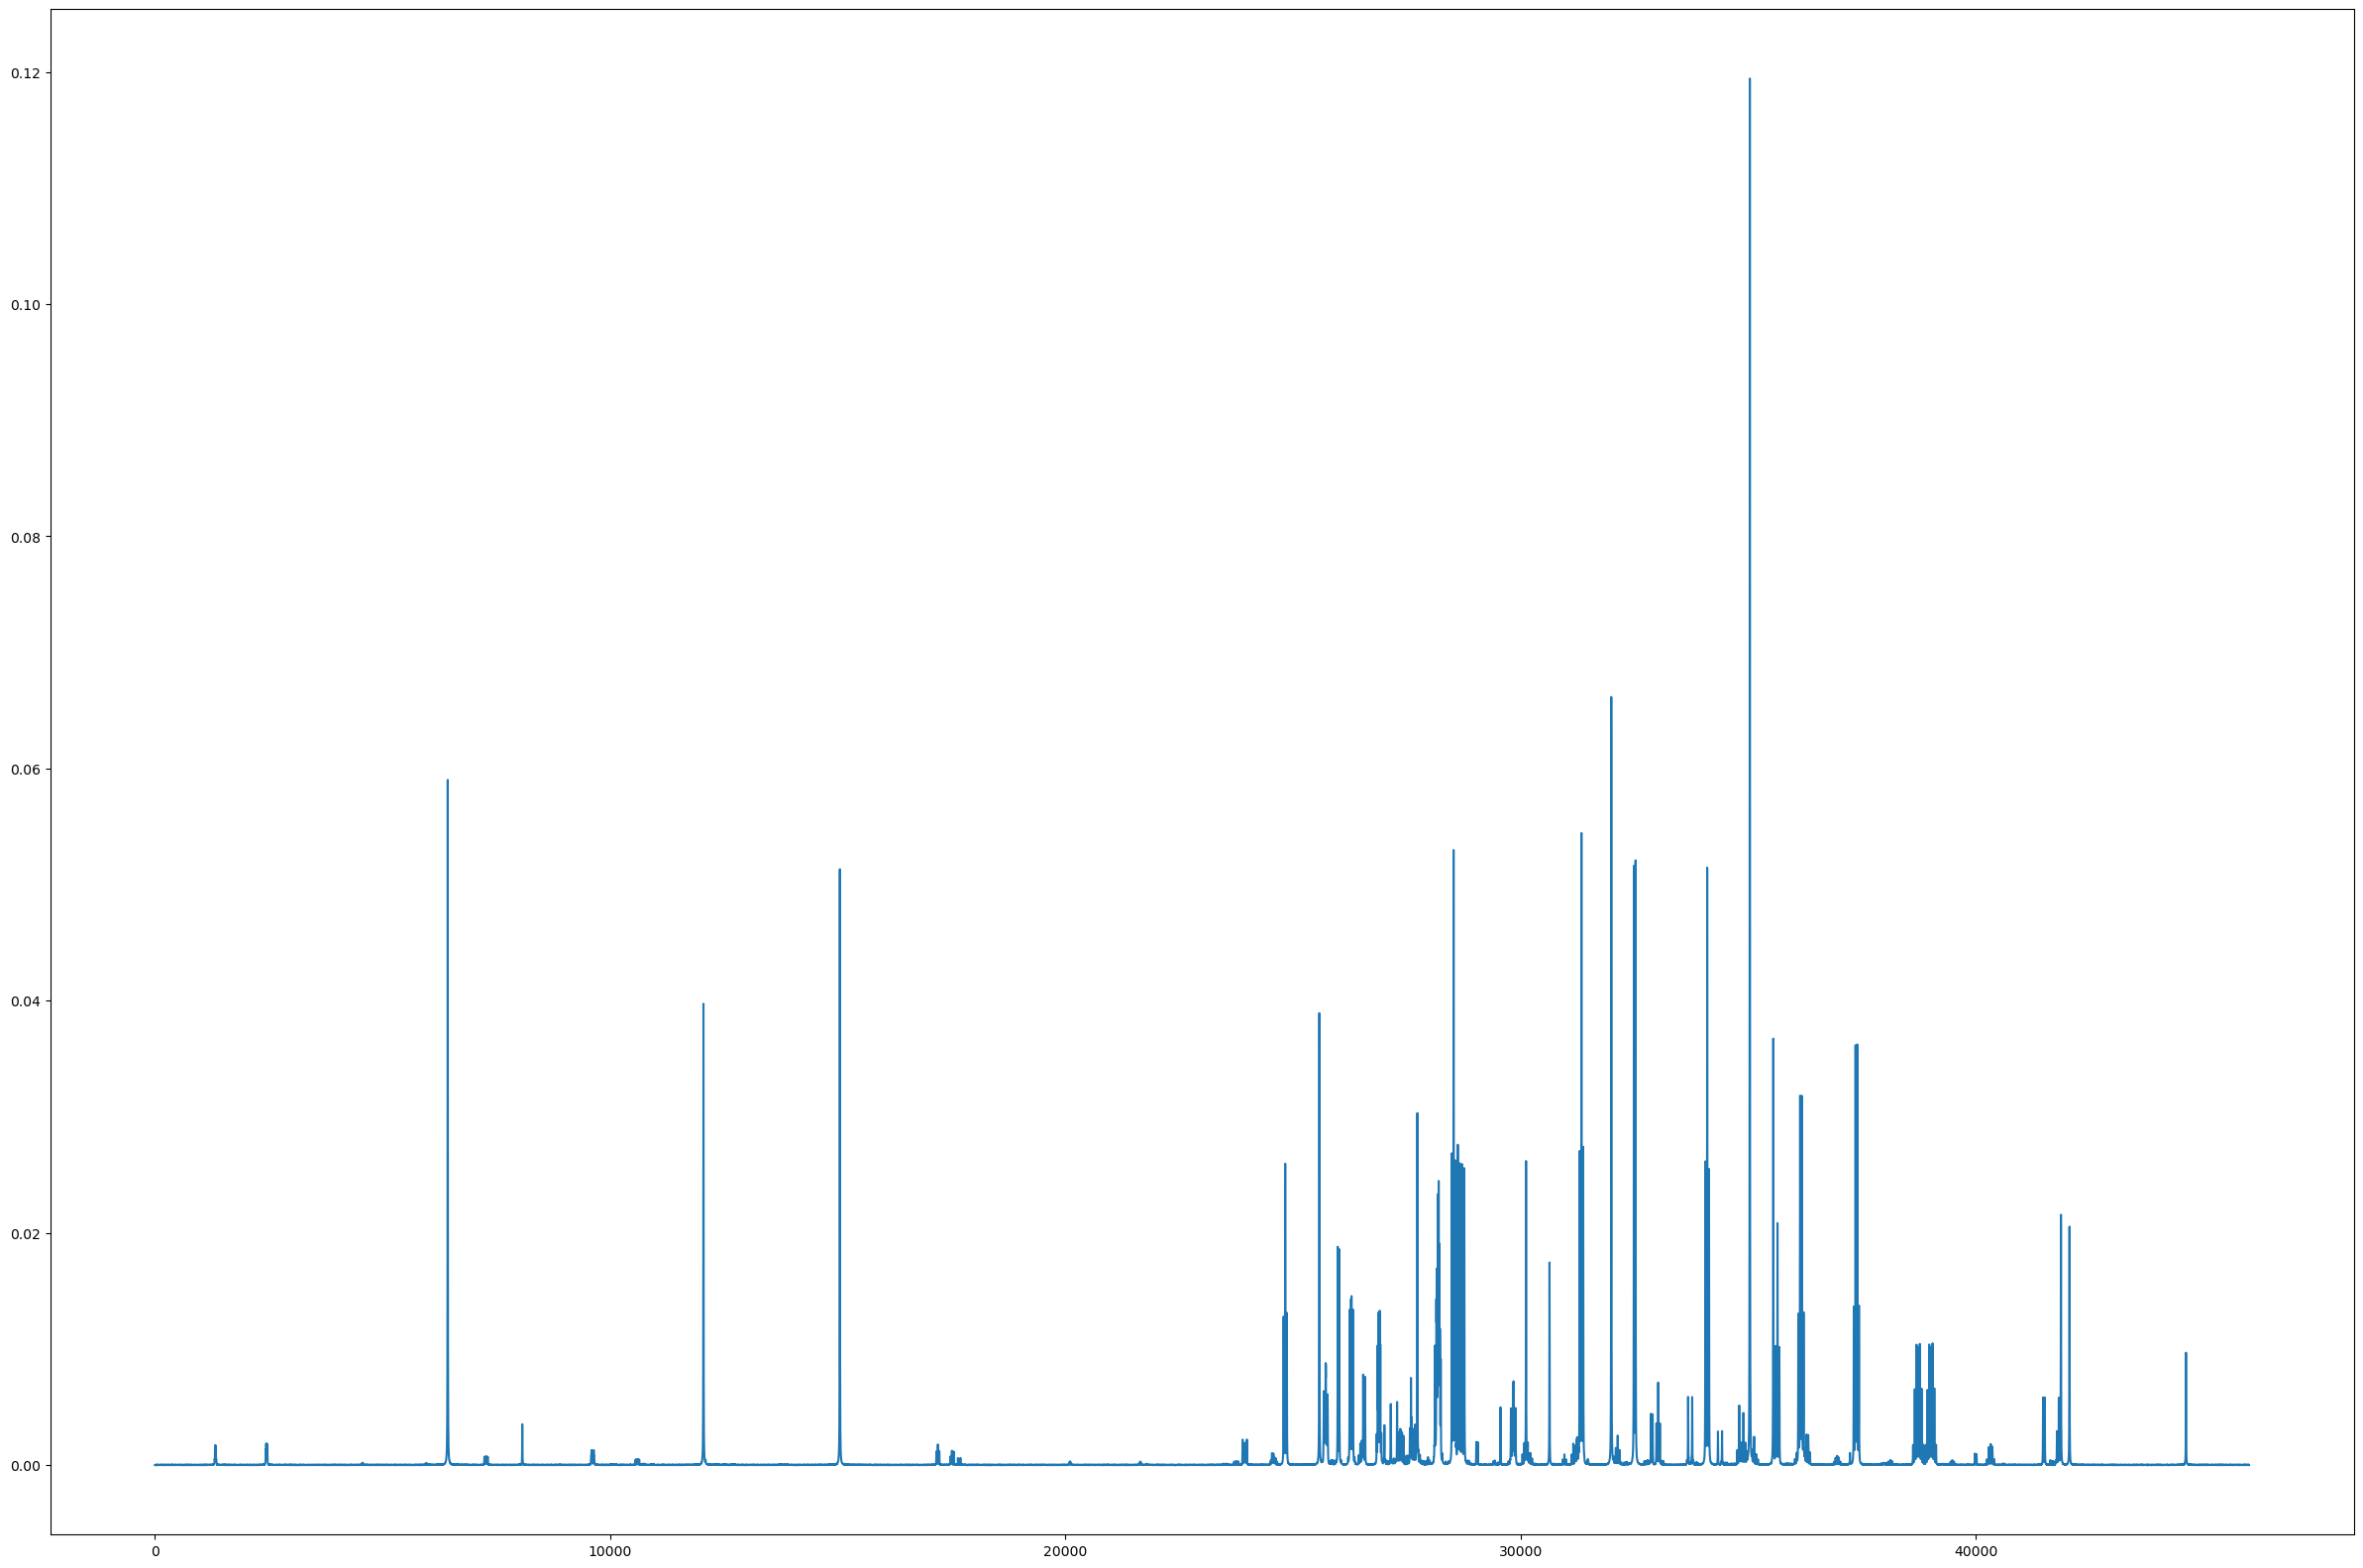

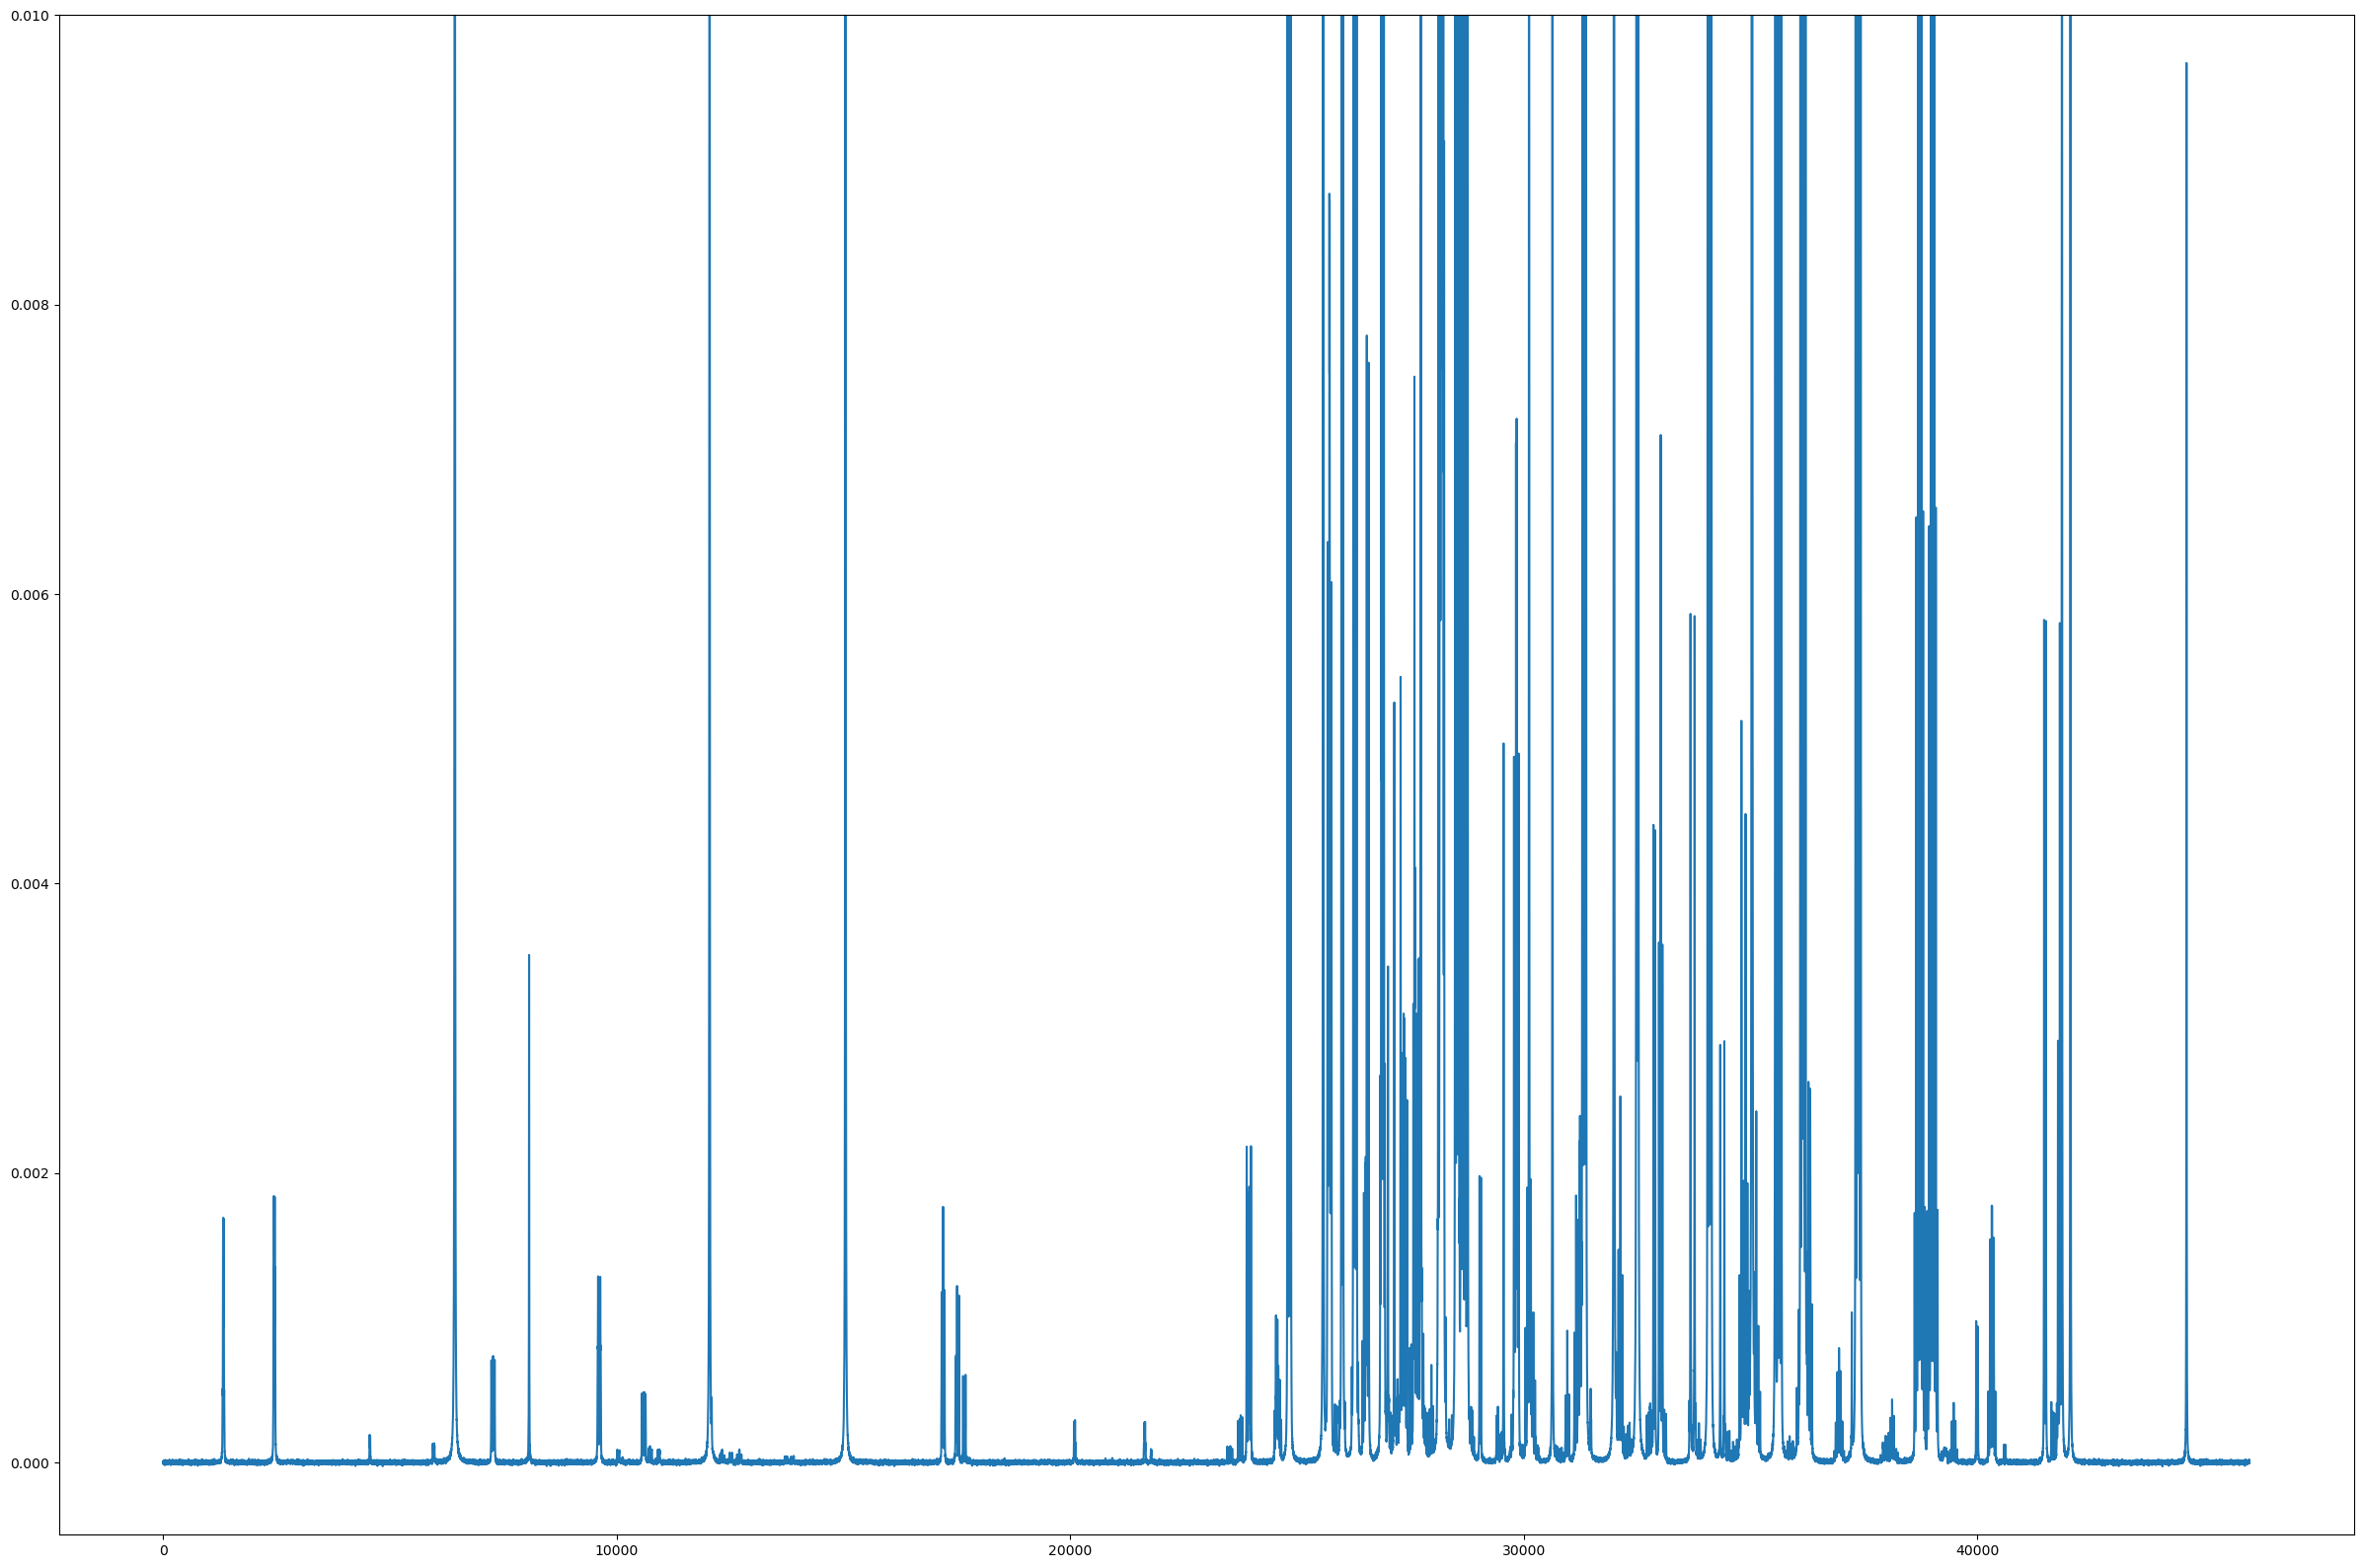

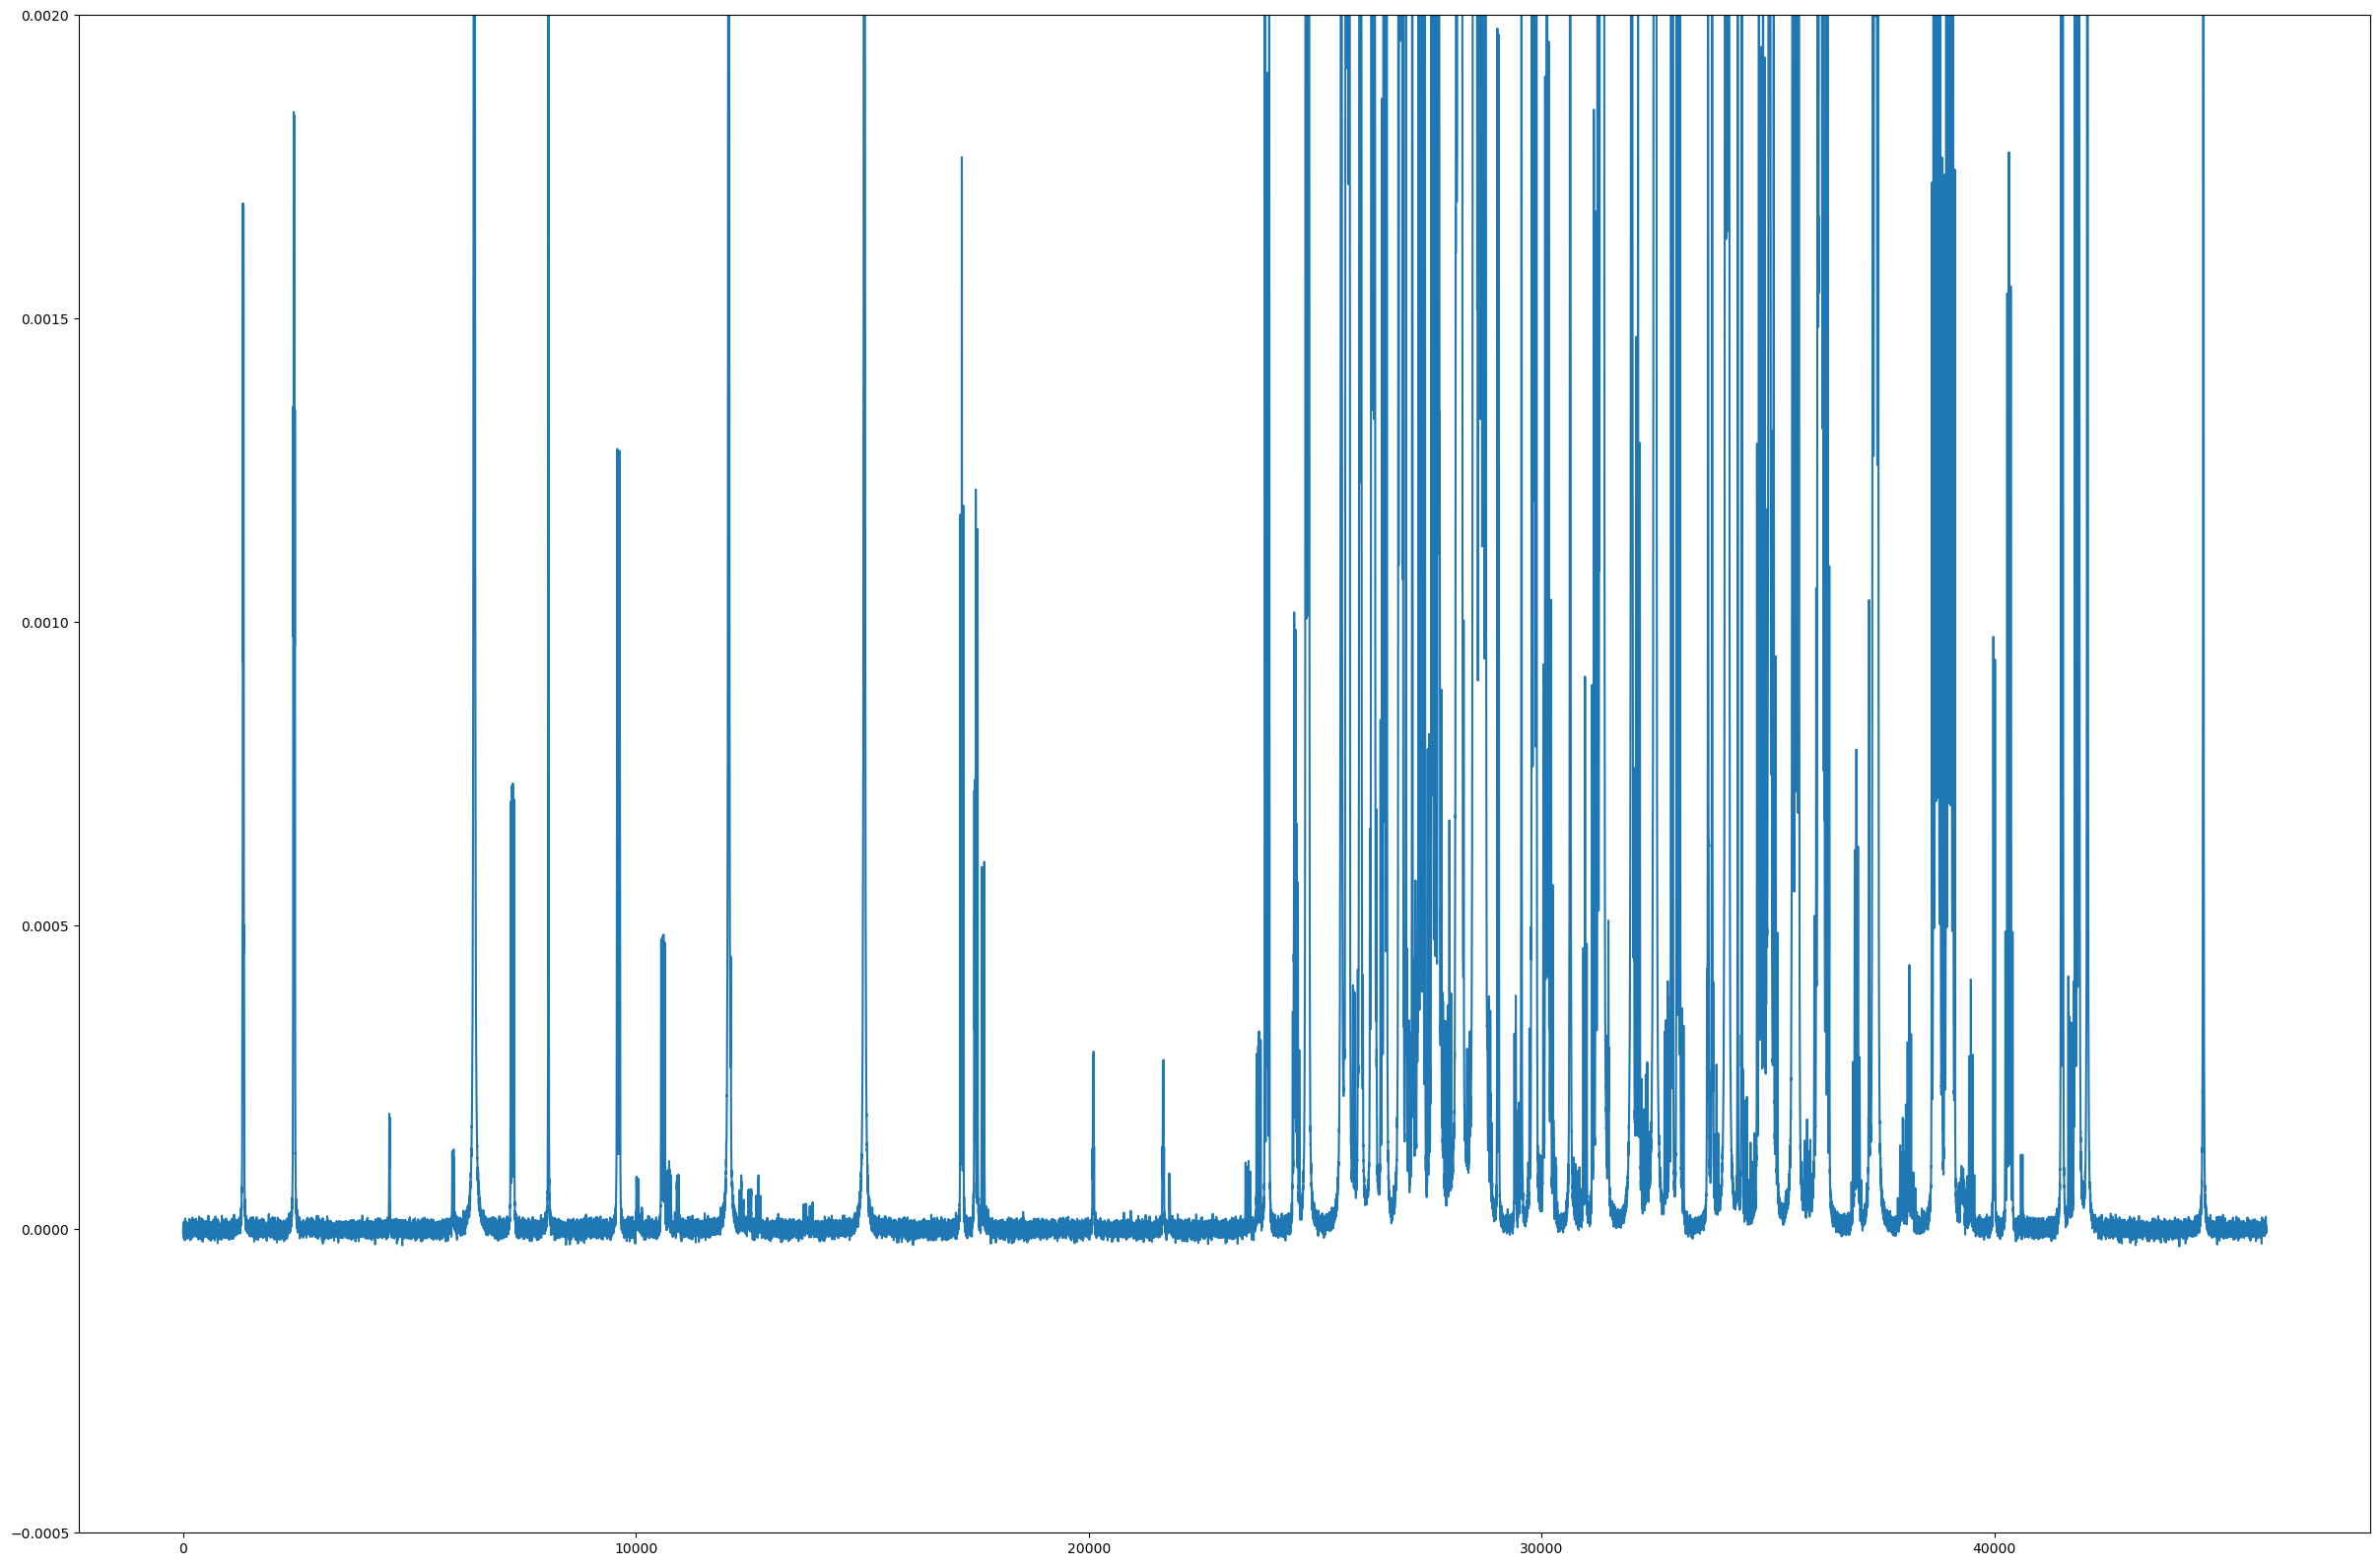

In [20]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [21]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  6.0199833
--------------------
6.63  - Min Value: 0.0139  - Mean Value: 0.9
11.66  - Min Value: 0.0139  - Mean Value: 0.7
4.55  - Min Value: 0.0139  - Mean Value: 0.6
5.77  - Min Value: 0.0139  - Mean Value: 1.1
7.01  - Min Value: 0.0139  - Mean Value: 1.0
4.55  - Min Value: 0.0139  - Mean Value: 0.9
5.48  - Min Value: 0.0139  - Mean Value: 0.5
5.75  - Min Value: 0.0139  - Mean Value: 0.7
5.65  - Min Value: 0.0139  - Mean Value: 0.7
3.16  - Min Value: 0.0139  - Mean Value: 0.5


In [22]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  45.780544
--------------------
80.01  - Min Value: 0.0066  - Mean Value: 5.8
52.63  - Min Value: 0.0067  - Mean Value: 6.9
24.85  - Min Value: 0.0082  - Mean Value: 6.1
45.52  - Min Value: 0.0076  - Mean Value: 6.6
31.33  - Min Value: 0.0074  - Mean Value: 5.7
39.81  - Min Value: 0.01  - Mean Value: 6.6
25.35  - Min Value: 0.0113  - Mean Value: 7.9
52.84  - Min Value: 0.0059  - Mean Value: 7.3
58.18  - Min Value: 0.0069  - Mean Value: 7.6
47.29  - Min Value: 0.0083  - Mean Value: 6.7


In [23]:
ConcConc[5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [24]:
model_aq(ConcSpec[5])

tensor([[0.5045, 0.4918, 0.4997, 0.5048, 0.5034, 0.5004, 0.5035, 0.4988, 0.5015,
         0.5005, 0.5015, 0.5035, 0.5055, 0.4989, 0.4979, 0.5027, 0.5018, 0.5023,
         0.5022, 0.4973, 0.5012, 0.5015, 0.5007, 0.4997, 0.5008, 0.4963, 0.5016,
         0.5021, 0.5088, 0.4981, 0.4937, 0.5029, 0.5048, 0.5050, 0.5025, 0.5027,
         0.4958, 0.4974, 0.5031, 0.5047, 0.5010, 0.4991, 0.5055, 0.5016]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [25]:
ConcSpec.size()

torch.Size([10, 1, 46000])

In [26]:
SNR_Spec.size()

torch.Size([10, 1, 53500])

In [27]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x54784 and 47104x44)

In [ ]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

In [ ]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

In [ ]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])